In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise


The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
# your code goes here

import spacy, codecs, os
corpus_root = 'data/'
nlp = spacy.load('en_core_web_sm')
with codecs.open(os.path.join(corpus_root,"all_scripts.txt"),encoding="utf8") as f:
            book = f.read()
print(book[0:600])

>> Series 01 Episode 01 – Pilot Episode
> A corridor at a sperm bank.
Sheldon: So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.
Leonard: Agreed, what’s your point?
Sheldon: There’s no point, I just think it’s a good idea for a tee-shirt.
Leonard: Excuse me?
Receptionist: Hang on.
Leonard: One across is Aegean, eight down is Nabakov, twenty-six across is MCM, f


In [3]:
lines = book.splitlines() 
print(lines[0])

>> Series 01 Episode 01 – Pilot Episode


In [4]:
episodes=[]
scenes = []
characters = []
lineas = []
seasons = []

for linea in lines:
    if linea.startswith(">>"):
        episode = linea[2:]
        season = episode.split(' E')[0]
    else:
        if linea.startswith(">"):
            scene = linea[1:]
        else:
            character = linea.split(':')[0]
            line_said = linea.split(':')[1]
            seasons.append(season)
            episodes.append(episode)
            scenes.append(scene)
            characters.append(character)
            lineas.append(line_said)

row = {"season":seasons,"episode":episodes,"scene":scenes,"character":characters,"line":lineas}

data_frame = pd.DataFrame(data=row) 
data_frame.tail(10)

,season,episode,scene,character,line
51282,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon and Amy’s apartment.,Penny,"Don’t look at me like that, I tried."
51283,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon’s office.,Ramona,"Hey, did you eat yet?"
51284,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon’s office.,Sheldon,"Uh, breakfast yes, lunch no. I did have a cou..."
51285,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon’s office.,Ramona,"Well, perfect. I made us sandwiches."
51286,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon’s office.,Sheldon,How thoughtful. Thank you.
51287,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon’s office.,Ramona,"Mmm. No big deal, I enjoy spending time with ..."
51288,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon’s office.,Sheldon,"And I with you. Question, are you seeking a r..."
51289,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon’s office.,Ramona,What if I were?
51290,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Sheldon’s office.,Sheldon,"Well, that would raise a number of problems. ..."
51291,Series 10,Series 10 Episode 24 – The Long Distance Diss...,Princeton.,Sheldon,"(Knock, knock, knock) Amy. (Knock, knock, kno..."


In [5]:
var = data_frame.groupby(by=["season","episode"])
var = var.agg({"scene": "nunique"})
var = var.reset_index()
var.groupby(by="season")['scene'].sum()

season
 Series 01    157
 Series 02    205
 Series 03    193
 Series 04    219
 Series 05    198
 Series 06    211
 Series 07    207
 Series 08    191
 Series 09    177
 Series 10    189
Name: scene, dtype: int64

**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [6]:
# your code goes here
# Groupby episode and count unique values of character
characters=data_frame.groupby('character')['episode'].nunique()
# dialogs_per_episode = data_frame.groupby('episode')['character'].value_counts()
# dialogs_per_episode
dialogs_characters = data_frame.groupby('character').count()
recurrent_chars =np.array(dialogs_characters[dialogs_characters.episode>90].index)
recurrent_chars = np.delete(recurrent_chars,10)
recurrent_chars
# recurrent_chars = dialogs[lambda x:x>90].index.get_level_values('character').count()
# dialogs.apply(lambda g: g['character']>90)
# characters[lambda x:x>1]

array(['Amy', 'Arthur', 'Bernadette', 'Bert', 'Beverley', 'Emily',
       'Howard', 'Kripke', 'Leonard', 'Leslie', 'Mrs Cooper',
       'Mrs Wolowitz', 'Penny', 'Priya', 'Raj', 'Sheldon', 'Stuart',
       'Wil', 'Zack'], dtype=object)

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [7]:
# your code goes here
# Imported the set of exclude chars
from helpers.helper_functions import EXCLUDE_CHARS
EXCLUDE_CHARS
# function for replacing the exclude chars with a white space
def replaceExcludeChars(line):
    for character in EXCLUDE_CHARS:
        line = line.replace(character,' ')
    return line
# apply the function for each line
data_frame['line']=data_frame['line'].apply(replaceExcludeChars)
data_frame['line'][1]

' Agreed  what s your point '

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

Text(0.5, 1.0, 'corpus frequency Bar Chart')

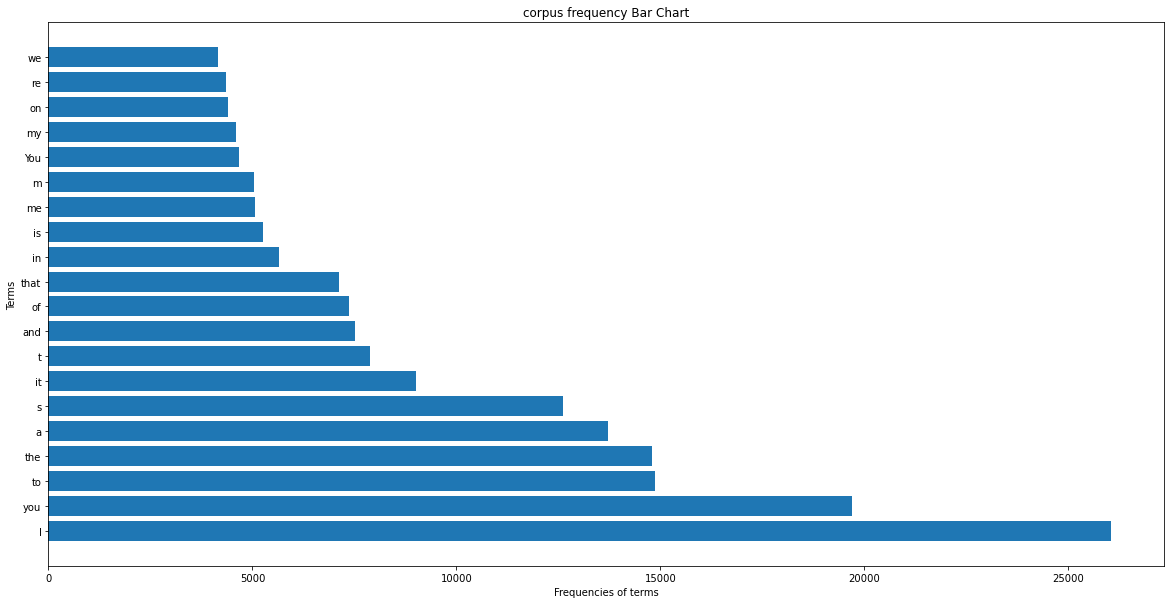

In [8]:
# your code goes here
frequency_terms = data_frame.line.str.split(expand=True).stack().value_counts()[:20]
plt.figure(figsize=(20,10))
plt.barh(frequency_terms.index,frequency_terms.values)
plt.xlabel('Frequencies of terms')
plt.ylabel('Terms')
plt.title('corpus frequency Bar Chart')

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

Text(0.5, 1.0, 'Recurrent Characters vs Total num words, Bar Chart')

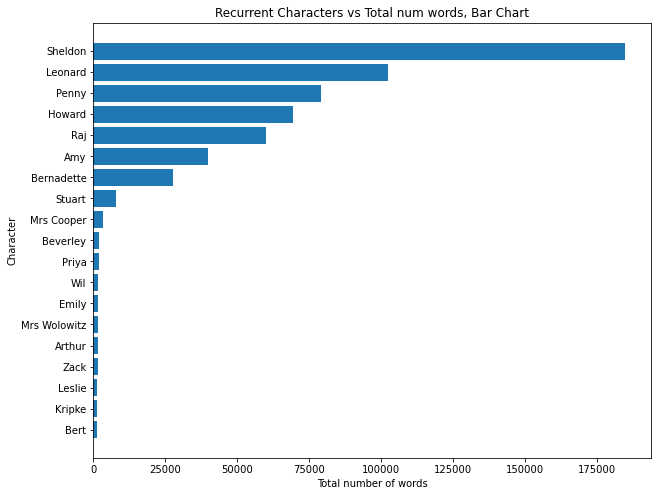

In [9]:
# your code goes here
pd.options.mode.chained_assignment = None  # default='warn'

df_recurrent_chars = data_frame[data_frame['character'].isin(recurrent_chars)] 
def count_words(line):
    return len(line.split())
df_recurrent_chars['words'] = df_recurrent_chars['line'].apply(count_words)
df_recurrent_chars.head()
words_per_character = df_recurrent_chars.groupby('character').words.sum().sort_values()
plt.figure(figsize=(10,8))
plt.barh(words_per_character.index,words_per_character.values)
plt.xlabel('Total number of words')
plt.ylabel('Character')
plt.title('Recurrent Characters vs Total num words, Bar Chart')

## Task C: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points (which is one row of your matrix) is one **dialogue line**. Now, use the scikit-learn class **TfIdfVectorizer** to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.

In [10]:
# your code goes here
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import simple_tokeniser

# Reading the stop words
stop_words = pd.read_csv('./helpers/stopwords.txt',sep='\n',header=None)

# Diving the DF in x_train and x_test
x_train = data_frame[~(data_frame['season']==' Series 09')]
x_train = x_train[~(x_train['season']==' Series 10')]
x_test = data_frame[(data_frame['season']==' Series 09')]
x_test = pd.concat([x_test, data_frame[(data_frame['season']==' Series 10')]])

tokeniser = x_train['line'].apply(simple_tokeniser)
# tokeniser_clean = [[]for in tokeniser]
# vectorizer = TfidfVectorizer()
# x_train = vectorizer.fit_transform(x_train['line'])
# vectorizer.get_feature_names_out()


**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [11]:
# your code goes here
# Getting from train the most common words of sheldon
from collections import Counter
stopwords=stop_words.values.tolist()
list_stopword = [item for sublist in stopwords for item in sublist]
x_train_sheldon = x_train[x_train['character'] == 'Sheldon']
x_train_sheldon = x_train_sheldon['line'].apply(simple_tokeniser)
frequency_words_by_line =[Counter(line) for line in x_train_sheldon]
total_frequency_words_sheldon = sum(frequency_words_by_line,Counter())
total_frequency_words_sheldon =total_frequency_words_sheldon.most_common()
common_words_clean = [word for word in total_frequency_words_sheldon if word[0].lower() not in list_stopword]


In [12]:
common_words_clean[:20]

[('Leonard', 659),
 ('know', 600),
 ('knock', 586),
 ('Well', 502),
 ('Penny', 483),
 ('like', 478),
 ('one', 473),
 ('right', 437),
 ('going', 390),
 ('would', 390),
 ('ve', 369),
 ('ll', 369),
 ('get', 334),
 ('think', 313),
 ('time', 294),
 ('go', 292),
 ('see', 289),
 ('Knock', 259),
 ('want', 258),
 ('d', 258)]

In [13]:
# Getting from test the most commons words of sheldon
x_test_sheldon = x_test[x_test['character'] == 'Sheldon']
x_test_sheldon = x_test_sheldon['line'].apply(simple_tokeniser)
frequency_words_by_line =[Counter(line) for line in x_test_sheldon]
total_frequency_words_sheldon_test = sum(frequency_words_by_line,Counter())
total_frequency_words_sheldon_test =total_frequency_words_sheldon_test.most_common()
common_words_test = [word for word in total_frequency_words_sheldon_test if word[0].lower() not in list_stopword]
common_words_test[:20]

[('know', 232),
 ('Well', 195),
 ('like', 162),
 ('Amy', 122),
 ('get', 115),
 ('Leonard', 108),
 ('ll', 107),
 ('one', 106),
 ('right', 102),
 ('ve', 86),
 ('think', 79),
 ('knock', 79),
 ('time', 75),
 ('going', 73),
 ('could', 72),
 ('would', 72),
 ('see', 69),
 ('d', 69),
 ('say', 68),
 ('need', 64)]

In [14]:
list_words_test =[word[0] for word in common_words_test[:20]]
[word[0] for word in common_words_clean[:20] if word[0] in list_words_test ]
# Con 20 palabras de training de sheldon y igual de test
# 16 palabras son las que se vuelven a repetir en test
# Podemos decir que con un 80% las palabras de test, son de sheldon.

['Leonard',
 'know',
 'knock',
 'Well',
 'like',
 'one',
 'right',
 'going',
 'would',
 've',
 'll',
 'get',
 'think',
 'time',
 'see',
 'd']

**Q8**. Now, perform singular value decomposition (SVD) on the training TF-IDF matrix, and calculate a **25-dimensional approximation** for both the training and test TF-IDF matrices (you can do this using scikit-learn's **TruncatedSVD** class). Then, train a logistic regression classifier with 10-fold cross-validation (using the scikit-learn **LogisticRegressionCV** class) on the output of the SVD that given a dialogue line, tells you whether it's by Sheldon or by someone else.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** Report precision, recall and F1-score for both classes (Sheldon and not-Sheldon), as well as accuracy, of your classifier on the training set and the test set. You need to implement the calculation of the evaluation measures (precision, etc.) yourself -- using the scikit-learn functions for them is not allowed.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** What difference do you observe between the model's scores on the training and test sets? What could you infer from the amount of difference you see? What about the difference between scores on the two classes? Given the performance of your classifier, is Leonard right that the accuracy Sheldon claims is unattainable? What about his suspicions about the lines that Sheldon can and cannot distinguish?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** List 10 of the most extreme false positives and 10 of the most extreme false negatives, in terms of the probabilities predicted by the logistic regression model. What are common features of false positives? What about the false negatives?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iv)** What is the most important feature in the model? What are the 5 most important words in this feature? _Hint: Think of the definition of an SVD, and that you did an SVD on the TF-IDF matrix with dialogue lines as rows and words as columns. You have projected the original data points onto a 25-dimensional subspace -- you need to look at the unit vectors you used for the projection._

In [15]:
# your code goes here